# Import rdkit and pandas

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Import covid Moonshot data

In [2]:
df = pd.read_csv("../Moonshot/COVID_moonshot_submissions/covid_submissions_all_info.csv")

"""
columns_of_interest = ["SMILES", "CID", "MW",
                       "cLogP", "TPSA", "Rotatable Bonds",
                       "Fraction sp3", "HBA", "HBD",
                       "r_curve_IC50_y", "f_curve_IC50_y"]]
"""

/tmp/ipykernel_7356/1585637510.py:1: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Moonshot/COVID_moonshot_submissions/covid_submissions_all_info.csv")


'\ncolumns_of_interest = ["SMILES", "CID", "MW",\n                       "cLogP", "TPSA", "Rotatable Bonds",\n                       "Fraction sp3", "HBA", "HBD",\n                       "r_curve_IC50_y", "f_curve_IC50_y"]]\n'

# Select column for prediction
# Clean df by removing NaN values

In [3]:
df_clogp = df[["cLogP","SMILES"]]
df_clogp[pd.to_numeric(df_clogp['cLogP'], errors='coerce').notnull()]
df_clogp.dropna(inplace=True)
show_df(df_clogp.head())

/tmp/ipykernel_7356/1144094518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clogp.dropna(inplace=True)


,cLogP,SMILES
0,2.61578,N#Cc1ccccc1NC(=O)Cc1c[nH]c2ncccc12
1,2.13448,N#Cc1ccccc1NC(=O)Cc1cccnc1
2,3.04758,CCNc1ccc(C#N)c(NC(=O)Cc2c[nH]c3ncccc23)c1
3,1.47150,CS(=O)(=O)Cc1ccc(C(=O)Nc2cccnc2)o1
4,1.88800,O=C(Nc1cccnc1)c1ccc(N2CCC(O)CC2)o1


# Add Molecule column to df using rdkit

In [4]:
PandasTools.AddMoleculeColumnToFrame(df_clogp,'SMILES','Molecule',includeFingerprints=True)

[22:48:25] WARNING: not removing hydrogen atom without neighbors
[22:48:25] WARNING: not removing hydrogen atom without neighbors
/home/nichrun/miniconda3/envs/PyTorchDrug/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(


# Machine learning imports

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

# Create training and test data. 

In [6]:
fps = [Chem.RDKFingerprint(x) for x in df_clogp["Molecule"]]
IC50_list = list(df_clogp["cLogP"])
X_train , X_test , y_train, y_test = train_test_split(fps, IC50_list, random_state=0)

# Train model

In [7]:
print("Instantiate model")
model = MLPRegressor(random_state=1, max_iter=500)
print("Training")
model.fit(X_train, y_train)
print("Predicting")
predictions = model.predict(X_test)
print("Evaluating")
r2_score(y_test, predictions)

Instantiate model
Training
Predicting
Evaluating


0.8113644150509645

# Visualising results

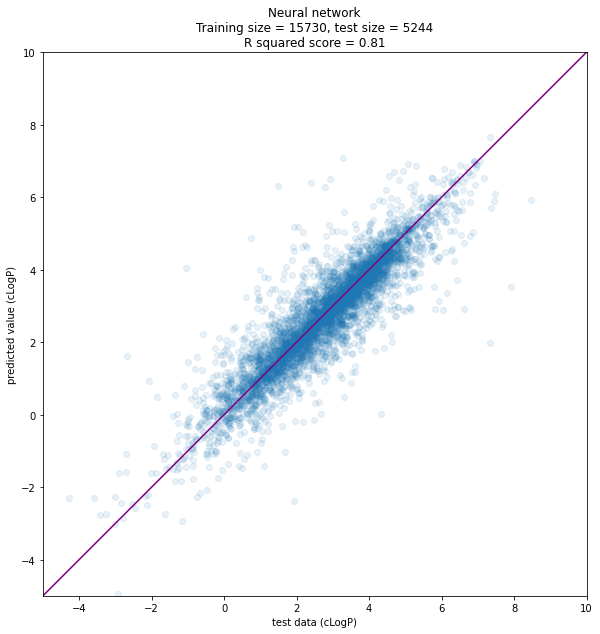

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

plt.scatter(y_test, predictions, alpha=0.1)
plt.xlim(-5,10)
plt.ylim(-5,10)

plt.plot([-5,10],[-5,10], color="purple")

ax.set_aspect('equal', adjustable='box')

plt.title(f"Neural network\nTraining size = {len(X_train)}, test size = {len(X_test)}\nR squared score = {round(r2_score(y_test, predictions), 2)}")
plt.xlabel("test data (cLogP)")
plt.ylabel("predicted value (cLogP)")
plt.show()